In [0]:
try:
  %tensorflow_version 2.x
except:
  pass
import pathlib

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

TensorFlow 2.x selected.
2.1.0-rc1


In [0]:
TRAIN_DATA_URL = "https://drive.google.com/uc?authuser=0&id=11uwGt8fNyHm5VJbmZU6BVhJja7gjQZVQ&export=download"
TEST_DATA_URL = "https://drive.google.com/uc?authuser=0&id=1oTfHdPxVShJOpJ8wbCP0VmymyE9m5iOf&export=download"

train_data_path = tf.keras.utils.get_file("train.csv", TRAIN_DATA_URL)
test_data_path = tf.keras.utils.get_file("test.csv", TEST_DATA_URL)

55762944/Unknown - 11s 0us/stepDownloading data from https://drive.google.com/uc?authuser=0&id=1oTfHdPxVShJOpJ8wbCP0VmymyE9m5iOf&export=download
29761536/Unknown - 6s 0us/step

In [0]:
# train_data_path = 'train.csv'
# test_data_path = 'test.csv'

In [0]:
column_names = ['date', 'in_out', 'latitude', 'longitude',
                '6~7_ride', '7~8_ride', '8~9_ride',
                '9~10_ride', '10~11_ride', '11~12_ride',
                '6~7_takeoff', '7~8_takeoff', '8~9_takeoff',
                '9~10_takeoff', '10~11_takeoff','11~12_takeoff', '18~20_ride']

train_raw = pd.read_csv(train_data_path, usecols=column_names,
                          na_values='?', skipinitialspace=True)

test_raw = pd.read_csv(test_data_path, usecols=column_names[:-1],
                       na_values='?', skipinitialspace=True)

In [0]:
def geo_idx(dd, dd_array):
    geo_idx = (np.abs(dd_array - dd)).argmin()
    return geo_idx

def make_dataset(df, grid_size):
    dataset = df.copy()
    # 평일, 주말, 휴일 feature 추가
    dataset['date'] = pd.to_datetime(dataset['date'])
    dataset['date_feature'] = dataset['date'].dt.weekday
    dataset.loc[dataset['date_feature'] < 5, 'date_feature'] = 0 # 0 => 평일
    dataset.loc[dataset['date_feature'] >= 5, 'date_feature'] = 1 # 1 => 주말
    
    holidays = pd.to_datetime(['2019-09-12', '2019-09-13', '2019-09-14', 
                           '2019-10-03', '2019-10-09'])
    dataset.loc[dataset['date'].isin(holidays), 'date_feature'] = 2 # 2 => 휴일
    
    # 시내, 시외
    dataset['in_out'] = dataset['in_out'].map({'시내': 0, '시외': 1})
    
    # grid index -> one hot encoding
    lon = np.linspace(train_raw['longitude'].min(), train_raw['longitude'].max(), grid_size)
    lat = np.linspace(train_raw['latitude'].min(), train_raw['latitude'].max(), grid_size)
    
    dataset['grid_lon'] = dataset['longitude'].map(lambda x: geo_idx(x, lon))
    dataset['grid_lat'] = dataset['latitude'].map(lambda x: geo_idx(x, lat))
    
    dataset = pd.get_dummies(dataset, columns=['grid_lon', 'grid_lat'])
    dataset.drop(['latitude', 'longitude', 'date'], 1, inplace=True)
    
    # datetime 2시간 간격으로 합치기
    dataset['68a'] = dataset.pop('6~7_ride') + dataset.pop('7~8_ride')
    dataset['810a'] = dataset.pop('8~9_ride') + dataset.pop('9~10_ride')
    dataset['1012a'] = dataset.pop('10~11_ride') + dataset.pop('11~12_ride')
    
    dataset['68b'] = dataset.pop('6~7_takeoff') + dataset.pop('7~8_takeoff')
    dataset['810b'] = dataset.pop('8~9_takeoff') + dataset.pop('9~10_takeoff')
    dataset['1012b'] = dataset.pop('10~11_takeoff') + dataset.pop('11~12_takeoff')
    
    return dataset

In [0]:
train_120 = make_dataset(train_raw, 120)
train_120_labels = train_120.pop('18~20_ride')
test_120 = make_dataset(test_raw, 120)
train_120.head()

,in_out,date_feature,grid_lon_0,grid_lon_1,grid_lon_2,grid_lon_3,grid_lon_4,grid_lon_5,grid_lon_6,grid_lon_7,grid_lon_8,grid_lon_9,grid_lon_10,grid_lon_11,grid_lon_12,grid_lon_13,grid_lon_14,grid_lon_15,grid_lon_16,grid_lon_17,grid_lon_18,grid_lon_19,grid_lon_20,grid_lon_21,grid_lon_22,grid_lon_23,grid_lon_24,grid_lon_25,grid_lon_26,grid_lon_27,grid_lon_28,grid_lon_29,grid_lon_30,grid_lon_31,grid_lon_32,grid_lon_33,grid_lon_34,grid_lon_35,grid_lon_36,grid_lon_37,...,grid_lat_27,grid_lat_28,grid_lat_29,grid_lat_30,grid_lat_31,grid_lat_32,grid_lat_33,grid_lat_34,grid_lat_35,grid_lat_36,grid_lat_37,grid_lat_38,grid_lat_39,grid_lat_40,grid_lat_41,grid_lat_42,grid_lat_43,grid_lat_44,grid_lat_45,grid_lat_46,grid_lat_47,grid_lat_48,grid_lat_49,grid_lat_50,grid_lat_51,grid_lat_52,grid_lat_53,grid_lat_54,grid_lat_55,grid_lat_115,grid_lat_116,grid_lat_117,grid_lat_118,grid_lat_119,68a,810a,1012a,68b,810b,1012b
0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,7.0,8.0,0.0,0.0,0.0
1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5.0,6.0,11.0,0.0,0.0,0.0
2,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2.0,2.0,0.0,0.0,0.0,0.0
3,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,17.0,32.0,30.0,0.0,0.0,0.0
4,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,1.0,0.0


In [0]:
set(train_120.columns) - set(test_120.columns)

set()

In [0]:
set(test_120.columns) - set(test_120.columns)

set()

In [0]:
numeric_columns = [
'68a', '810a', '1012a', '68b', '810b',
       '1012b'
]

categorical_columns = train_120.columns.difference(numeric_columns)

train_stats = train_120.describe()
train_stats.drop(categorical_columns, 1, inplace=True)
train_stats = train_stats.T
train_stats

,count,mean,std,min,25%,50%,75%,max
68a,415423.0,1.135592,2.863275,0.0,0.0,0.0,1.0,114.0
810a,415423.0,1.457825,3.716359,0.0,0.0,0.0,1.0,181.0
1012a,415423.0,1.179010,3.361951,0.0,0.0,0.0,1.0,174.0
68b,415423.0,0.457741,1.533075,0.0,0.0,0.0,0.0,85.0
810b,415423.0,0.947403,2.672530,0.0,0.0,0.0,1.0,86.0
1012b,415423.0,0.810875,2.509226,0.0,0.0,0.0,1.0,108.0


In [0]:
def norm(x):
    return (x - train_stats['mean']) / train_stats['std']

normed_train_data = norm(train_120[numeric_columns])
normed_train_data[categorical_columns] = train_120[categorical_columns]
normed_test_data = norm(test_120[numeric_columns])
normed_test_data[categorical_columns] = test_120[categorical_columns]


normed_train_data= normed_train_data.apply(lambda x: np.log(x+1))
normed_test_data= normed_test_data.apply(lambda x: np.log(x+1))

In [0]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure(figsize=(8,12))

  plt.subplot(2,1,1)
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [MPG]')
  plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
  plt.ylim([0,5])
  plt.legend()

  plt.subplot(2,1,2)
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$MPG^2$]')
  plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
  plt.ylim([0,20])
  plt.legend()
  plt.show()

In [0]:
SUB_MISSION_URL = "https://drive.google.com/a/dacon.io/uc?authuser=0&id=1jti3rkMN-Tb_WLOIeGVVFDYd_rfE9TFe&export=download"
submission_path = tf.keras.utils.get_file("submission_sample.csv", SUB_MISSION_URL)

2285568/Unknown - 0s 0us/step

In [0]:
# submission_path = 'submission_sample.csv'

In [0]:
def make_submission(model, train_data, train_labels, test_data):
    early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

    EPOCHS = 1000
    history = model.fit(train_data, train_labels, epochs=EPOCHS, batch_size=1000,
                        validation_split=0.2, verbose=2, callbacks=[early_stop])

    plot_history(history)

    predictions = model.predict(test_data)

    submission = pd.read_csv(submission_path)
    submission['18~20_ride'] = predictions
    
    return submission

Train on 332338 samples, validate on 83085 samples
Epoch 1/1000
332338/332338 - 3s - loss: 13.8374 - mae: 1.2632 - mse: 13.8374 - val_loss: 8.3081 - val_mae: 1.1643 - val_mse: 8.3081
Epoch 2/1000
332338/332338 - 3s - loss: 10.5590 - mae: 1.1669 - mse: 10.5590 - val_loss: 7.5949 - val_mae: 1.0772 - val_mse: 7.5949
Epoch 3/1000
332338/332338 - 3s - loss: 9.8385 - mae: 1.1387 - mse: 9.8385 - val_loss: 7.3564 - val_mae: 1.0916 - val_mse: 7.3564
Epoch 4/1000
332338/332338 - 3s - loss: 9.4880 - mae: 1.1298 - mse: 9.4880 - val_loss: 7.3205 - val_mae: 1.0097 - val_mse: 7.3205
Epoch 5/1000
332338/332338 - 3s - loss: 9.2232 - mae: 1.1199 - mse: 9.2232 - val_loss: 7.0818 - val_mae: 0.9908 - val_mse: 7.0818
Epoch 6/1000
332338/332338 - 3s - loss: 8.9944 - mae: 1.1140 - mse: 8.9944 - val_loss: 7.5224 - val_mae: 1.0368 - val_mse: 7.5224
Epoch 7/1000
332338/332338 - 3s - loss: 8.8849 - mae: 1.1068 - mse: 8.8849 - val_loss: 7.2508 - val_mae: 1.0821 - val_mse: 7.2508
Epoch 8/1000
332338/332338 - 3s - l

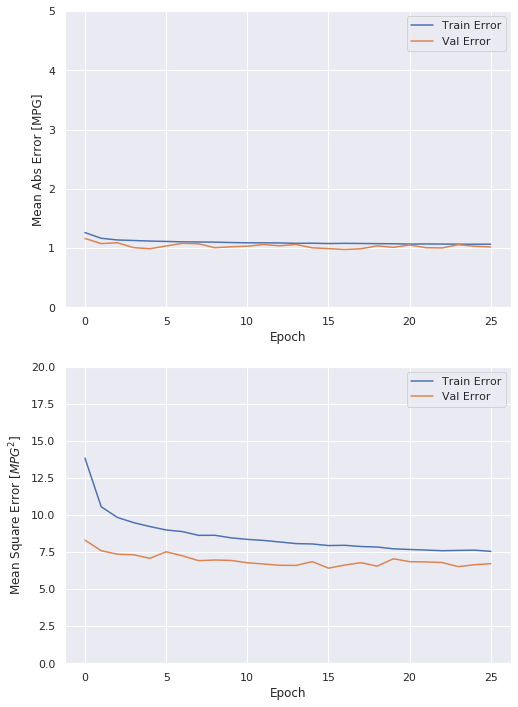

In [0]:
model = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=[len(normed_train_data.keys())]),
    layers.Dense(128, activation='relu'),
    layers.Dense(1)
])

model.compile(
    loss='mean_squared_error',
    optimizer='adam',
    metrics=['mae', 'mse']
)

submission1 = make_submission(model, normed_train_data, train_120_labels, normed_test_data)

Train on 332338 samples, validate on 83085 samples
Epoch 1/1000
332338/332338 - 4s - loss: 14.2685 - mae: 1.2720 - mse: 14.2685 - val_loss: 8.4423 - val_mae: 1.0985 - val_mse: 8.4423
Epoch 2/1000
332338/332338 - 3s - loss: 10.7749 - mae: 1.1780 - mse: 10.7749 - val_loss: 7.8039 - val_mae: 1.0225 - val_mse: 7.8039
Epoch 3/1000
332338/332338 - 3s - loss: 10.1344 - mae: 1.1558 - mse: 10.1344 - val_loss: 7.4837 - val_mae: 1.0633 - val_mse: 7.4837
Epoch 4/1000
332338/332338 - 3s - loss: 9.8513 - mae: 1.1472 - mse: 9.8513 - val_loss: 7.3870 - val_mae: 1.0794 - val_mse: 7.3870
Epoch 5/1000
332338/332338 - 3s - loss: 9.6026 - mae: 1.1412 - mse: 9.6026 - val_loss: 7.3515 - val_mae: 1.0288 - val_mse: 7.3515
Epoch 6/1000
332338/332338 - 3s - loss: 9.4530 - mae: 1.1345 - mse: 9.4530 - val_loss: 7.2491 - val_mae: 0.9964 - val_mse: 7.2491
Epoch 7/1000
332338/332338 - 3s - loss: 9.1843 - mae: 1.1229 - mse: 9.1843 - val_loss: 7.2107 - val_mae: 1.0054 - val_mse: 7.2107
Epoch 8/1000
332338/332338 - 3s -

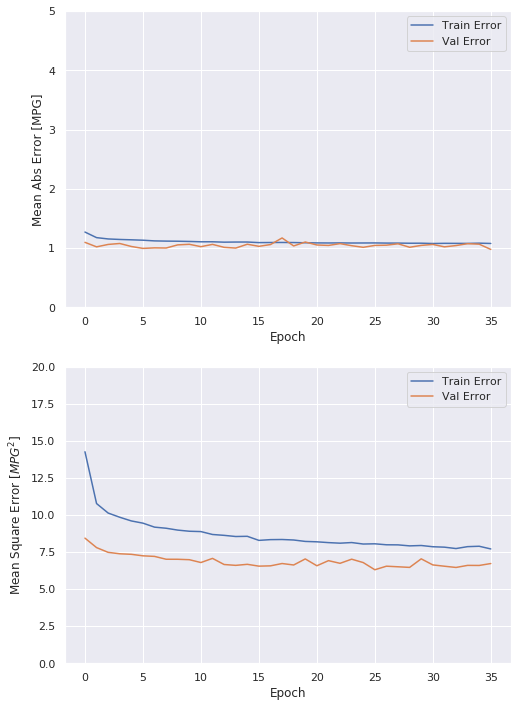

In [0]:
model = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=[len(normed_train_data.keys())]),
    layers.Dropout(0.2),
    layers.Dense(128, activation='relu'),
    layers.Dense(1)
])

model.compile(
    loss='mean_squared_error',
    optimizer='adam',
    metrics=['mae', 'mse']
)

submission2 = make_submission(model, normed_train_data, train_120_labels, normed_test_data)

In [0]:
train_80 = make_dataset(train_raw, 80)
train_80_labels = train_80.pop('18~20_ride')
test_80 = make_dataset(test_raw, 80)

categorical_columns = train_80.columns.difference(numeric_columns)

train_stats = train_80.describe()
train_stats.drop(categorical_columns, 1, inplace=True)
train_stats = train_stats.T

normed_train_data = norm(train_80[numeric_columns])
normed_train_data[categorical_columns] = train_80[categorical_columns]
normed_test_data = norm(test_80[numeric_columns])
normed_test_data[categorical_columns] = test_80[categorical_columns]

normed_train_data= normed_train_data.apply(lambda x: np.log(x+1))
normed_test_data= normed_test_data.apply(lambda x: np.log(x+1))

Train on 332338 samples, validate on 83085 samples
Epoch 1/1000
332338/332338 - 3s - loss: 13.9392 - mae: 1.2721 - mse: 13.9392 - val_loss: 8.4138 - val_mae: 1.1627 - val_mse: 8.4138
Epoch 2/1000
332338/332338 - 2s - loss: 10.7037 - mae: 1.1839 - mse: 10.7037 - val_loss: 8.1815 - val_mae: 1.0442 - val_mse: 8.1815
Epoch 3/1000
332338/332338 - 2s - loss: 10.0734 - mae: 1.1607 - mse: 10.0734 - val_loss: 7.8458 - val_mae: 1.1224 - val_mse: 7.8458
Epoch 4/1000
332338/332338 - 2s - loss: 9.7908 - mae: 1.1509 - mse: 9.7908 - val_loss: 7.7382 - val_mae: 1.0766 - val_mse: 7.7382
Epoch 5/1000
332338/332338 - 2s - loss: 9.5658 - mae: 1.1439 - mse: 9.5658 - val_loss: 7.9094 - val_mae: 1.0825 - val_mse: 7.9094
Epoch 6/1000
332338/332338 - 2s - loss: 9.3864 - mae: 1.1378 - mse: 9.3864 - val_loss: 7.6254 - val_mae: 1.0313 - val_mse: 7.6254
Epoch 7/1000
332338/332338 - 2s - loss: 9.3391 - mae: 1.1387 - mse: 9.3391 - val_loss: 7.5932 - val_mae: 1.0650 - val_mse: 7.5932
Epoch 8/1000
332338/332338 - 2s -

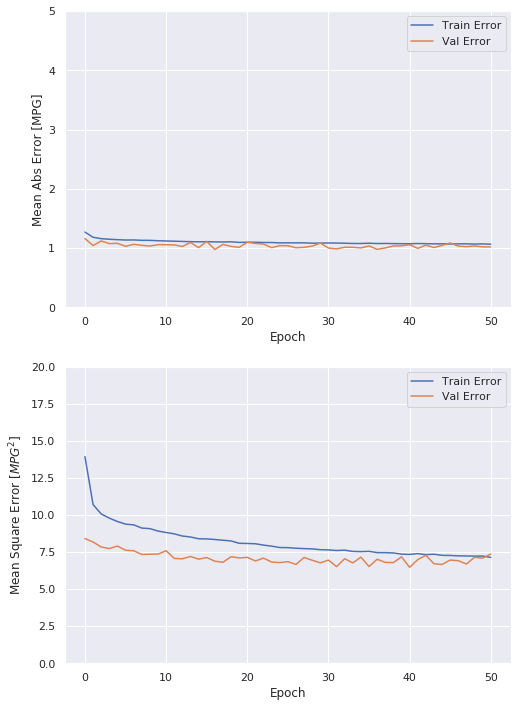

In [0]:
model = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=[len(normed_train_data.keys())]),
    layers.Dense(128, activation='relu'),
    layers.Dense(1)
])

model.compile(
    loss='mean_squared_error',
    optimizer='adam',
    metrics=['mae', 'mse']
)

submission3 = make_submission(model, normed_train_data, train_80_labels, normed_test_data)

Train on 332338 samples, validate on 83085 samples
Epoch 1/1000
332338/332338 - 3s - loss: 14.2677 - mae: 1.2827 - mse: 14.2677 - val_loss: 8.5011 - val_mae: 1.1449 - val_mse: 8.5011
Epoch 2/1000
332338/332338 - 3s - loss: 11.0115 - mae: 1.2024 - mse: 11.0115 - val_loss: 7.8681 - val_mae: 1.0787 - val_mse: 7.8681
Epoch 3/1000
332338/332338 - 3s - loss: 10.3030 - mae: 1.1796 - mse: 10.3030 - val_loss: 7.7740 - val_mae: 1.0796 - val_mse: 7.7740
Epoch 4/1000
332338/332338 - 3s - loss: 9.9573 - mae: 1.1696 - mse: 9.9573 - val_loss: 8.3611 - val_mae: 1.0461 - val_mse: 8.3611
Epoch 5/1000
332338/332338 - 3s - loss: 9.7624 - mae: 1.1583 - mse: 9.7624 - val_loss: 7.4820 - val_mae: 1.0951 - val_mse: 7.4820
Epoch 6/1000
332338/332338 - 3s - loss: 9.6799 - mae: 1.1528 - mse: 9.6799 - val_loss: 7.8858 - val_mae: 1.0430 - val_mse: 7.8858
Epoch 7/1000
332338/332338 - 3s - loss: 9.4198 - mae: 1.1500 - mse: 9.4198 - val_loss: 7.5724 - val_mae: 1.0845 - val_mse: 7.5724
Epoch 8/1000
332338/332338 - 3s -

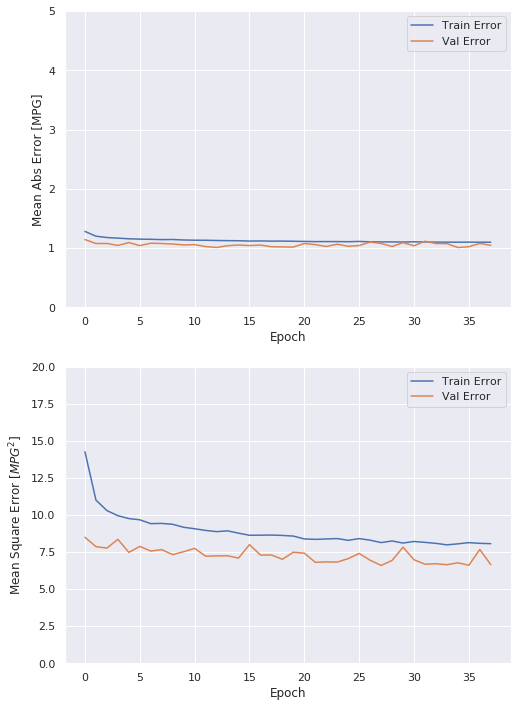

In [0]:
model = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=[len(normed_train_data.keys())]),
    layers.Dropout(0.2),
    layers.Dense(128, activation='relu'),
    layers.Dense(1)
])

model.compile(
    loss='mean_squared_error',
    optimizer='adam',
    metrics=['mae', 'mse']
)

submission4 = make_submission(model, normed_train_data, train_80_labels, normed_test_data)

In [0]:
submission = (submission1 + submission2 + submission3 + submission4) *0.25
submission.to_csv('submission_0000.csv', index=False)